<a href="https://colab.research.google.com/github/almendruki/Cosas-TDA/blob/main/Almendra_Orellana_Figueroa_Clase_10_Practica_TDA_PDs_Distancias_y_Descriptores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clase 10 — Distancias entre diagramas de persistencia, estabilidad y descriptores topológicos (Práctica)


Este tutorial acompaña la clase teórica sobre:
- Distancias entre diagramas de persistencia (Wasserstein y *bottleneck*)
- Teoremas de estabilidad (para Rips/Čech)
- Descriptores topológicos (Betti/Euler curves, *Persistence Landscapes*, *Persistence Images*)
- Breve ejemplo de clasificacion de datasets simples según sus formas.

> **Objetivo:** **construir** diagramas de persistencia con `ripser` y `gudhi`, **compararlos** con distancias clásicas, y **vectorizarlos** para usarlos en *ML*.

> **Lectura base:** “Distancias entre diagramas de persistencia, estabilidad, y el uso de descriptores topológicos (Clase 9)” (diapositivas del curso).

---


## 0. Instalación




In [ ]:
!pip install ripser
!pip install POT
!pip install gudhi
!pip install persim
!pip install scikit-tda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
# 1) Imports y utilidades
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

%matplotlib inline

# Intentamos importar librerías TDA; si faltan, mostramos mensajes amigables.
try:
    from ripser import ripser
    from persim import plot_diagrams
except Exception as e:
    print("[Aviso] Problema importando ripser/persim:", e)

try:
    import gudhi as gd
    from gudhi.wasserstein import wasserstein_distance
    from gudhi import bottleneck_distance
except Exception as e:
    print("[Aviso] Problema importando gudhi:", e)

### Generación de datos

In [ ]:
# ---------------------
# Generación de datos
# ---------------------
def sample_circle(n=200, r=1.0, noise=0.02, seed=0):
    rng = np.random.default_rng(seed)
    angles = rng.uniform(0, 2*np.pi, n)
    X = np.c_[r*np.cos(angles), r*np.sin(angles)]
    X += rng.normal(scale=noise, size=X.shape)
    return X

def sample_two_circles(n=400, r1=1.0, r2=0.5, offset=2.5, noise=0.02, seed=1):
    rng = np.random.default_rng(seed)
    X1 = sample_circle(n//2, r=r1, noise=noise, seed=seed)
    X2 = sample_circle(n//2, r=r2, noise=noise, seed=seed+1)
    X2[:,0] += offset
    return np.vstack([X1, X2])

def sample_figure8(n=400, r=1.0, offset=1.2, noise=0.02, seed=2):
    rng = np.random.default_rng(seed)
    X1 = sample_circle(n//2, r=r, noise=noise, seed=seed)
    X2 = sample_circle(n//2, r=r, noise=noise, seed=seed+1)
    X2[:,0] += offset
    return np.vstack([X1, X2])

def jitter_points(X, sigma=0.02, seed=123):
    rng = np.random.default_rng(seed)
    return X + rng.normal(scale=sigma, size=X.shape)

### Hausdorff distance

In [ ]:
# ---------------------
# Hausdorff distance (discreto, simétrico)
# ---------------------
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

def hausdorff_distance(A, B, metric="euclidean"):
    """
    Calcula la distancia Hausdorff entre dos conjuntos de puntos A y B.

    Param:
        A (np.ndarray): A set of points.
        B (np.ndarray): A set of points.
        metric (str): la métrica a usar euclideana por defecto.

    Retorna:
        float: The Hausdorff distance.
    """
    # calcula la matrix de todos los pares de distancias entre A y B una vez
    dist_matrix = pairwise_distances(A, B, metric=metric)

    # Calcula la distancia directa de A a B
    h_A_B = np.max(np.min(dist_matrix, axis=1))

    # Calcula la distancia directa de B a A
    # La transpuesta (dist_matrix.T) representa las distancias de B a A
    h_B_A = np.max(np.min(dist_matrix.T, axis=1))

    # La distancia Hausdorff es el maximo entre las dos distancias directas
    d_H = np.max([h_A_B, h_B_A])

    return d_H

### Persistence diagram helpers, descriptors and distances

In [ ]:
# ---------------------
# Diagram helpers
# ---------------------
def ripser_diagrams(X, maxdim=1, thresh=None):
    th = np.inf if thresh is None else thresh
    res = ripser(X, maxdim=maxdim, thresh=th, distance_matrix=False)
    return res['dgms']  # lista de arrays por dimensión

def gudhi_rips_diagrams(X, maxdim=1, max_edge_length=None):
    max_edge = np.inf if max_edge_length is None else max_edge_length
    rc = gd.RipsComplex(points=X, max_edge_length=max_edge)
    st = rc.create_simplex_tree(max_dimension=maxdim+1)
    st.compute_persistence()
    dgms = []
    # como gudhi tiene los intervalos (dim, [birth, death]) lo homogenizamos con el formato de ripser
    # una lista de listas de intervalos
    for dim in range(maxdim+1):
        d = st.persistence_intervals_in_dimension(dim)
        # Gudhi usa 'inf' para muertes infinitas; lo dejamos así para compatibilidad con persim
        dgms.append(np.array(d, dtype=float))
    return dgms

# ---------------------
# Betti y Euler curves desde PD (grid sobre el parámetro de filtración t)
# ---------------------
def betti_curve_from_diagram(diag: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    """Cuenta, para cada t en t_grid, cuántos intervalos (b,d) activan: b <= t < d.
    diag: array de pares (b,d) (puede contener d = inf)"""
    if diag.size == 0:
        return np.zeros_like(t_grid, dtype=float)
    b = diag[:, 0] # todos los births
    d = diag[:, 1] # todos los deaths
    out = np.zeros_like(t_grid, dtype=float)
    for i, t in enumerate(t_grid):
        out[i] = np.sum((b <= t) & (t < d)) # número de intervalos de persistencia "vivos" en el tiempo t
    return out

def euler_curve_from_diagrams(diagrams: List[np.ndarray], t_grid: np.ndarray) -> np.ndarray:
    """E(t) = sum_k (-1)^k * beta_k(t)"""
    E = np.zeros_like(t_grid, dtype=float)
    for k, Dk in enumerate(diagrams):
        if Dk.size == 0:
            continue
        E += ((-1)**k) * betti_curve_from_diagram(Dk, t_grid)
    return E

# ---------------------
# Paisajes de persistencia (versión simple)
# ---------------------
def _hat_height(t, b, d):
    # Triangular hat: max(0, min(t-b, d-t))
    if np.isinf(d):
        # Si la muerte es infinita, acotamos artificialmente (para visualización)
        d = b + 2.0
    return max(0.0, min(t - b, d - t))

def persistence_landscapes(diag: np.ndarray, t_grid: np.ndarray, k_max=3) -> np.ndarray:
    """Devuelve una matriz (k_max, len(t_grid)) con los k primeros paisajes."""
    L = np.zeros((k_max, len(t_grid)), dtype=float)
    if diag.size == 0:
        return L
    for j, t in enumerate(t_grid):
        vals = [_hat_height(t, b, d) for (b, d) in diag]
        vals.sort(reverse=True)
        m = min(k_max, len(vals))
        L[:m, j] = vals[:m]
    return L

# ---------------------
# Distancias entre diagramas (envolturas)
# ---------------------
def bottleneck(D1, D2, dimension=1):
    try:
        return bottleneck_distance(D1[dimension], D2[dimension])
    except Exception:
        return None

def wasserstein(D1, D2, dimension=1, p=2):
    try:
        return wasserstein_distance(D1[dimension], D2[dimension], order=p, internal_p=2.0)
    except Exception:
        return None



## 1. Calentamiento: datos sintéticos y primeros diagramas

**Actividad guiada:** genera un conjunto de puntos y calcula sus diagramas de persistencia con `ripser` **y** con `gudhi`. Luego, compara visualmente.


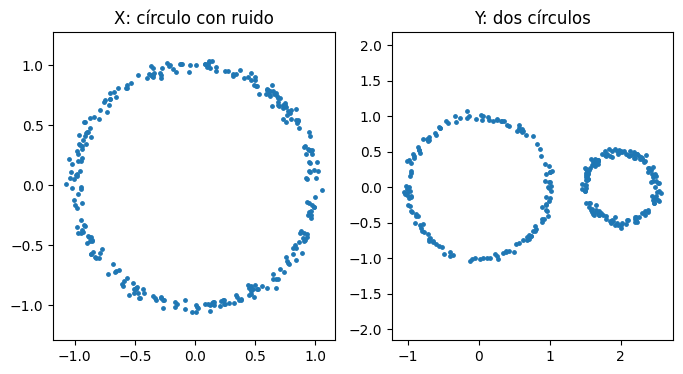

In [ ]:

# Datos
X = sample_circle(n=300, r=1.0, noise=0.03, seed=42)
Y = sample_two_circles(n=300, r1=1.0, r2=0.5, offset=2.0, noise=0.03, seed=7)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(X[:,0], X[:,1], s=6); ax[0].set_title("X: círculo con ruido"); ax[0].axis('equal')
ax[1].scatter(Y[:,0], Y[:,1], s=6); ax[1].set_title("Y: dos círculos"); ax[1].axis('equal')
plt.show()


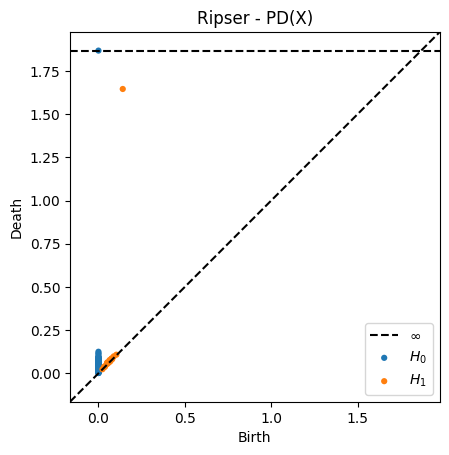

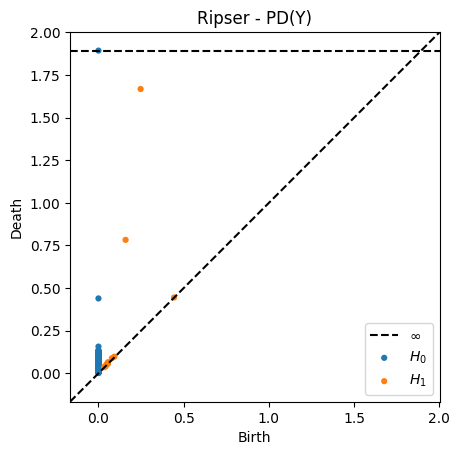

In [ ]:
# Diagramas con ripser
try:
    D_X_rip = ripser_diagrams(X, maxdim=1)
    D_Y_rip = ripser_diagrams(Y, maxdim=1)

    plot_diagrams(D_X_rip, show=False); plt.title("Ripser - PD(X)"); plt.show()
    plot_diagrams(D_Y_rip, show=False); plt.title("Ripser - PD(Y)"); plt.show()
except Exception as e:
    print("[Aviso] No se pudo ejecutar ripser/plot_diagrams:", e)


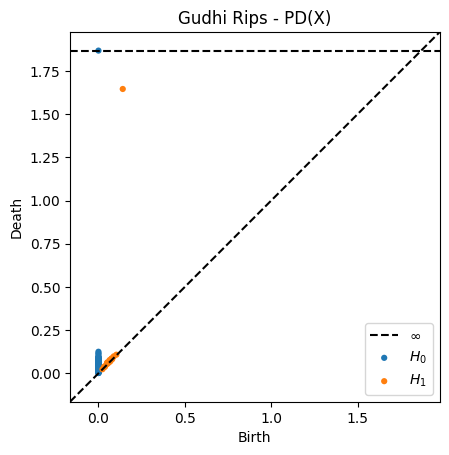

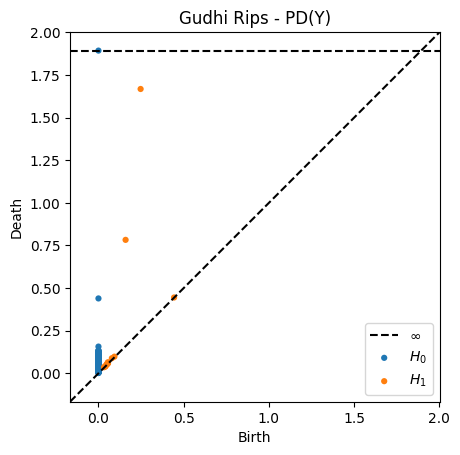

In [ ]:

# Diagramas con Gudhi (RipsComplex)
try:
    D_X_gd = gudhi_rips_diagrams(X, maxdim=1)
    D_Y_gd = gudhi_rips_diagrams(Y, maxdim=1)
    # Intentamos graficar con persim si está
    try:
        plot_diagrams(D_X_gd, show=False); plt.title("Gudhi Rips - PD(X)"); plt.show()
        plot_diagrams(D_Y_gd, show=False); plt.title("Gudhi Rips - PD(Y)"); plt.show()
    except Exception:
        print("Diags listos en D_X_gd y D_Y_gd.")
except Exception as e:
    print("[Aviso] No se pudo ejecutar Gudhi:", e)



**❓Preguntas guiadas**  
1. ¿Qué diferencias percibes en los diagramas de `H0` y `H1` entre **X** y **Y**?  
2. ¿Qué efecto produce el **ruido** sobre la vida de las clases en `H1`?  
3. ¿Qué cambiaría si aumentamos el parámetro `max_edge_length` en `Gudhi`?
4. ¿Qué cambiaría si aumentamos el parámetro `thresh` en `Ripser`?



## 2. Distancias entre diagramas: *bottleneck* y Wasserstein

Recordatorio: en las diapositivas se definen las distancias para medidas discretas y su extensión a diagramas, con “emparejamiento a la diagonal”.


In [ ]:

# Distancias para PD(X) y PD(Y) en H1
try:
    dB = bottleneck(D_X_gd, D_Y_gd, dimension=1)
    dW1 = wasserstein(D_X_gd, D_Y_gd, dimension=1, p=1)
    dW2 = wasserstein(D_X_gd, D_Y_gd, dimension=1, p=2)
    print(f"Bottleneck H1 = {dB}")
    print(f"Wasserstein p=1 H1 = {dW1}")
    print(f"Wasserstein p=2 H1 = {dW2}")
except Exception as e:
    print("[Aviso] No se pudieron calcular distancias:", e)


Bottleneck H1 = 0.3119149392093502
Wasserstein p=1 H1 = 0.6078632228186162
Wasserstein p=2 H1 = 0.4546503839256173



**🧪 Prueba rápida**  
Cambia **Y** por un **círculo** *más ruidoso* en lugar de dos círculos. ¿Cómo varían las distancias `d_B`, `W1`, `W2` frente a `X`?



## 3. Estabilidad: comparando `d_B` con la distancia de Hausdorff

Para Rips, el teorema visto en clase (forma clásica) acota la distancia de *bottleneck* de los PDs por (una constante veces) la distancia de Hausdorff entre los conjuntos subyacentes. Aquí haremos un experimento numérico simple.


In [ ]:

# Experimento de estabilidad
X0 = sample_circle(n=250, r=1.0, noise=0.01, seed=0)
X1 = jitter_points(X0, sigma=0.03, seed=1)

try:
    DX0 = gudhi_rips_diagrams(X0, maxdim=1)
    DX1 = gudhi_rips_diagrams(X1, maxdim=1)
    dB_X = bottleneck(DX0, DX1, dimension=1)
except Exception as e:
    dB_X = None
    print("[Aviso] No se pudo calcular d_B:", e)

dH = hausdorff_distance(X0, X1)

print(f"Hausdorff(X0,X1) = {dH:.4f}")
print(f"Bottleneck(PD(X0), PD(X1)) H1 = {dB_X}")
print("Comparación (numérica, esperable): d_B ≲ C * d_H para un C acorde al complejo usado.")


Hausdorff(X0,X1) = 0.0820
Bottleneck(PD(X0), PD(X1)) H1 = 0.07452660838899194
Comparación (numérica, esperable): d_B ≲ C * d_H para un C acorde al complejo usado.



**❓Preguntas guiadas**  
1. ¿Qué ocurre con `d_B` cuando incrementas la **perturbación** (parámetro `sigma`)?  
2. ¿Ves casos en que los ciclos “persistentes” sean **estables** frente al ruido?  
3. Intenta el mismo experimento para `H0`. ¿Qué observas?



## 4. (Opcional) Čech vs Rips en práctica

`Gudhi` no implementa directamente Čech en 2D con “bolas completas”, pero se puede aproximar con **AlphaComplex** o comparar **Rips** a distintas escalas. Repite el cómputo con `max_edge_length` variando y observa la aparición/desaparición de ciclos en `H1`.


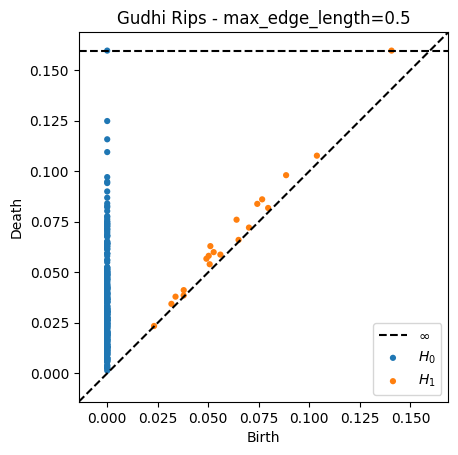

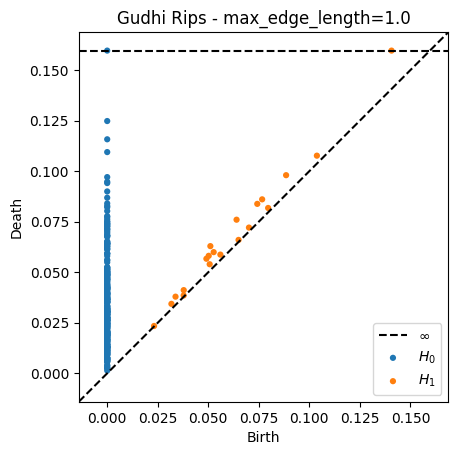

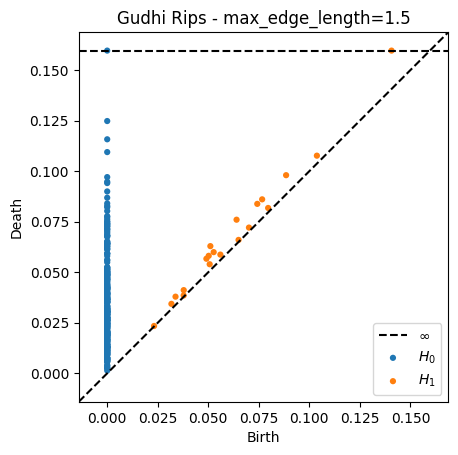

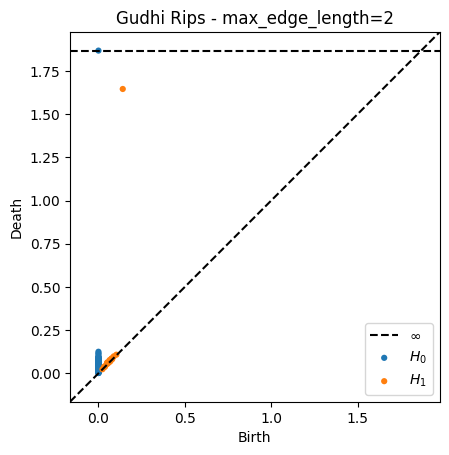

In [ ]:

# Opcional: exploración de escalas con Gudhi.RipsComplex
try:
    for L in [0.5, 1.0, 1.5, 2]:
        D = gudhi_rips_diagrams(X, maxdim=1, max_edge_length=L)
        plot_diagrams(D, show=False); plt.title(f"Gudhi Rips - max_edge_length={L}"); plt.show()
except Exception as e:
    print("[Aviso] Exploración Rips opcional falló:", e)



## 5. Descriptores: Betti/Euler curves y *Persistence Landscapes*

- **Betti curve** de dimensión $k$: $\beta_k(t) = \#\{(b,d) : b\le t < d\}$.  
- **Euler curve**: $E(t) = \sum_k (-1)^k\,\beta_k(t)$.  
- **Persistence Landscapes**: superposición de “sombreros” $f_{b,d}(t)=\max\{0,\min(t-b, d-t)\}$; el paisaje $\lambda_k(t)$ es la $k$-ésima mayor altura en $t$.


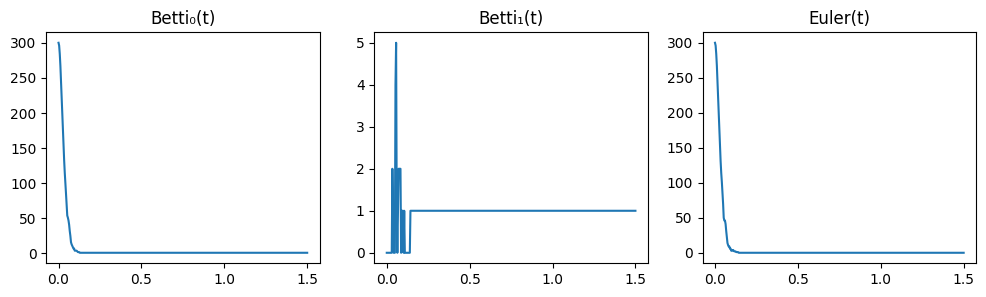

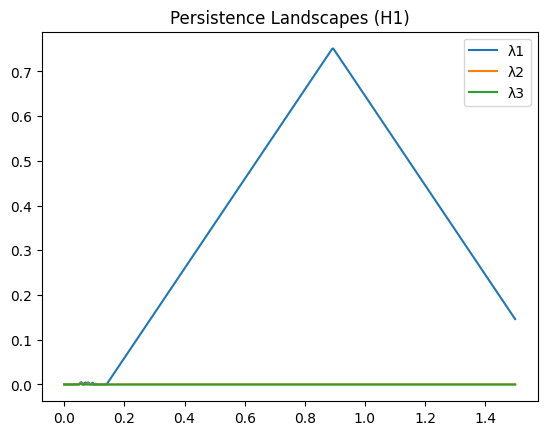

In [ ]:

# Curvas de Betti/Euler y paisajes (versión simple)
t_grid = np.linspace(0, 1.5, 400)

try:
    D = D_X_gd  # Usa los diagramas de X (Gudhi)
    beta0 = betti_curve_from_diagram(D[0], t_grid) if len(D) > 0 else np.zeros_like(t_grid)
    beta1 = betti_curve_from_diagram(D[1], t_grid) if len(D) > 1 else np.zeros_like(t_grid)
    E = euler_curve_from_diagrams(D, t_grid)

    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].plot(t_grid, beta0); ax[0].set_title("Betti₀(t)")
    ax[1].plot(t_grid, beta1); ax[1].set_title("Betti₁(t)")
    ax[2].plot(t_grid, E);     ax[2].set_title("Euler(t)")
    plt.show()

    # Paisajes (primeros 3) para H1
    L = persistence_landscapes(D[1], t_grid, k_max=3)
    for k in range(L.shape[0]):
        plt.plot(t_grid, L[k], label=f"λ{k+1}")
    plt.title("Persistence Landscapes (H1)")
    plt.legend(); plt.show()
except Exception as e:
    print("[Aviso] No se pudieron construir curvas/paisajes:", e)



**🧪 Prueba rápida**  
Cambia **X** por **Y** y vuelve a dibujar las curvas/paisajes. ¿Cómo se reflejan los **dos ciclos** de `Y` en `Betti₁(t)` y en los paisajes?



## 6. (Opcional) Persistence Images

Si tienes `persim` moderno, puedes usar `PersistenceImager`. Alternativamente, implementa una **discretización** sencilla con kernels gaussianos.


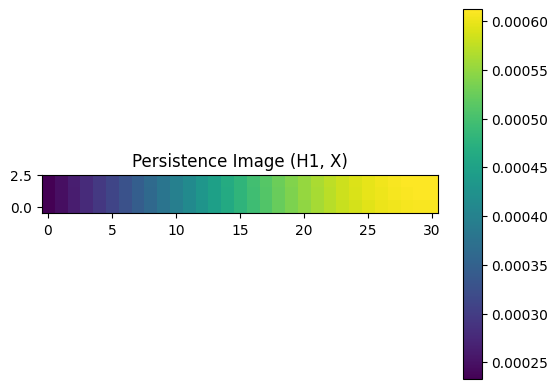

In [ ]:

# Opcional: Persistence Images con persim (si está disponible)
try:
    from persim import PersistenceImager
    # Tomamos H1 de X
    PD = D_X_gd[1]
    pimgr = PersistenceImager(pixel_size=0.05)  # Ajusta resolución si quieres
    pimgr.fit(PD)
    PI = pimgr.transform(PD)
    plt.imshow(PI, origin='lower'); plt.title("Persistence Image (H1, X)"); plt.colorbar(); plt.show()
except Exception as e:
    print("[Aviso] PersistenceImager no disponible:", e)


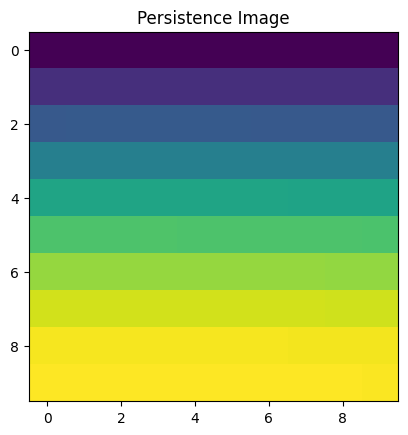

In [ ]:

# Opcional: Persistence Images con persim (si está disponible)
# mas ejemplos en https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-representations.ipynb
try:
    from gudhi.representations import PersistenceImage
    # Tomamos H1 de X
    PD = [D_X_gd[1]]
    PI = PersistenceImage(resolution=[10,10]).fit_transform(PD)
    fig, axes = plt.subplots(1, 1)
    ax = plt
    ax.title("Persistence Image")
    ax.imshow(np.flip(np.reshape(PI, [10, 10]), 0))
    plt.show()
except Exception as e:
    print("[Aviso] PersistenceImager no disponible:", e)



## 7. Mini demo de clasificación con descriptores

Construye un conjunto etiquetado mezclando `X` (1 ciclo) vs `Y` (2 ciclos) y entrena una regresión logística con features simples:  
- Área bajo Betti₁(t), máximo de `λ₁(t)`, media de `Euler(t)`, etc.


In [ ]:

# Opcional: features sencillos + clasificación
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    def features_from_pd_list(D_list, t_grid):
        feats = []
        for D in D_list:
            b0 = betti_curve_from_diagram(D[0], t_grid) if len(D)>0 else np.zeros(t_grid)
            b1 = betti_curve_from_diagram(D[1], t_grid) if len(D)>1 else np.zeros(t_grid)
            E  = euler_curve_from_diagrams(D, t_grid)
            L  = persistence_landscapes(D[1], t_grid, k_max=3) if len(D)>1 else np.zeros((3,len(t_grid)))
            feats.append([
                np.trapz(b1, t_grid),          # área bajo Betti1
                b1.max(),                      # peak Betti1
                L[0].max() if L.size>0 else 0, # peak λ1
                np.trapz(np.abs(E), t_grid),   # área Euler
            ])
        return np.array(feats)

    # Dataset: 100 muestras de cada tipo
    Ds, ys = [], []
    for i in range(100):
        Xi = sample_circle(n=200, noise=0.03, seed=i)
        Yi = sample_two_circles(n=200, noise=0.03, seed=1000+i)
        Dx = ripser_diagrams(Xi, maxdim=1)
        Dy = ripser_diagrams(Yi, maxdim=1)
        Ds += [Dx, Dy]
        ys += [0, 1]

    Xfeat = features_from_pd_list(Ds, t_grid)
    y = np.array(ys)

    Xtr, Xte, ytr, yte = train_test_split(Xfeat, y, test_size=0.3, random_state=0, stratify=y)
    clf = LogisticRegression(max_iter=200).fit(Xtr, ytr)
    pred = clf.predict(Xte)
    print("Accuracy:", accuracy_score(yte, pred))
except Exception as e:
    print("[Aviso] Saltando demo de clasificación:", e)


Accuracy: 1.0



---

## Para discutir
- ¿Qué descriptor te parecería más **robusto** en algún dominio aplicado?
- ¿Cuándo preferirías comparar con **distancias** directamente en vez de vectorizar?
- Implicancias computacionales: ¿qué pasa con $n$ grande y complejos en altas dimensiones?

**Fin de la práctica.**
